In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import scanpy.external as sce
import decoupler as dc
# import scrublet as scr
# import muon as mu
#from vpolo.alevin import parser # to parse alevin output
import matplotlib.pyplot as plt
import seaborn as sns

# import scvi
# import torch

import statsmodels.api as sm
import statsmodels.stats.multitest as multi
from adjustText import adjust_text
import re

seed = 0
np.random.seed(seed)
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = (1,1,1,1)
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [4]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
# sc.settings.set_figure_params(dpi=80, color_map='viridis', transparent=False, frameon=False)  # low dpi (dots per inch) yields small inline figures

import matplotlib as mpl
# 2 lines below solved the facecolor problem.
# mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = (1,1,1,1)
sc.settings.autosave = True
sc.logging.print_header()

version = '250417_CSFMac_MS'

import os
os.makedirs('../scanpy/{}'.format(version), exist_ok=True)

sc.settings.figdir = '../scanpy/{}/graph'.format(version)
sc.settings.cachedir = '../scanpy/{}/cache'.format(version)
# %config InlineBackend.figure_format = 'retina'

import os
os.makedirs('../scanpy/{}'.format(version), exist_ok=True)
os.makedirs(sc.settings.figdir, exist_ok=True)

2025-04-24 22:22:44.210760: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-24 22:22:44.226016: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-24 22:22:44.241387: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-24 22:22:44.245617: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-24 22:22:44.259014: I tensorflow/core/platform/cpu_feature_guar

scanpy==1.10.2 anndata==0.10.9 umap==0.5.6 numpy==1.26.4 scipy==1.13.0 pandas==2.2.3 scikit-learn==1.5.1 statsmodels==0.14.2 igraph==0.11.6 pynndescent==0.5.13


In [5]:
# adata_query = sc.read('../scanpy/250411_MS_scanvi/merged.CSF_MSandHA_integrated_60704.scanvi.h5ad')
adata_query = sc.read('../scanpy/250417_MS_scanvi/merged.CSF_MSandHA_integrated_60704.scanvi.h5ad')

Only considering the two last: ['.scanvi', '.h5ad'].
Only considering the two last: ['.scanvi', '.h5ad'].


/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [4]:
adata_ref = sc.read('/home/yy693/pi_hafler/ASAP/scanpy/250407_CSF_downstream/res.h5ad')

In [5]:
adata_query

AnnData object with n_obs × n_vars = 212827 × 17308
    obs: 'patient', 'disease', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'SampleID', '_scvi_batch', 'cluster_L2_scanvi', '_scvi_labels', 'predictions_scanvi', 'leiden'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'leiden', 'log1p', 'neighbors', 'umap'
    obsm: 'X_scANVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

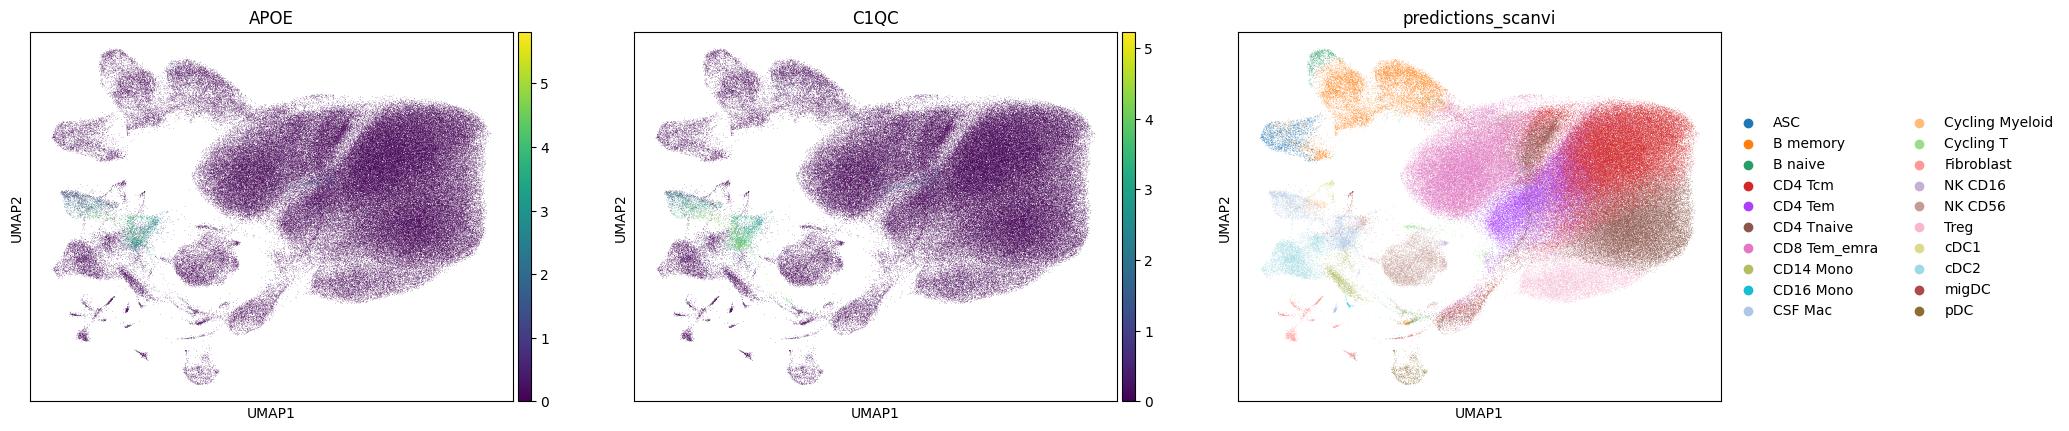

In [6]:
sc.pl.umap(adata_query, color=['APOE', 'C1QC', 'predictions_scanvi'])

In [7]:
df_freq = pd.crosstab(adata_query.obs['patient'], adata_query.obs['predictions_scanvi'])
df_freq = (df_freq.T / df_freq.sum(axis=1)).T
df_freq = pd.merge(df_freq, adata_query.obs[['patient', 'disease']].drop_duplicates(),
         left_index=True, right_on='patient', how='left')

In [8]:
df_freq

,ASC,B memory,B naive,CD4 Tcm,CD4 Tem,CD4 Tnaive,CD8 Tem_emra,CD14 Mono,CD16 Mono,CSF Mac,...,Fibroblast,NK CD16,NK CD56,Treg,cDC1,cDC2,migDC,pDC,patient,disease
AAACCTGAGCATGGCA-1,0.000000,0.002876,0.000000,0.318313,0.136146,0.161074,0.160115,0.016299,0.001918,0.056568,...,0.000959,0.001918,0.046980,0.017258,0.001918,0.044104,0.001918,0.017258,HA5876,Healthy
AAACCTGCACTGTCGG-1,0.000000,0.000000,0.000000,0.368816,0.110945,0.109445,0.071964,0.014993,0.001499,0.088456,...,0.011994,0.002999,0.023988,0.019490,0.000000,0.103448,0.002999,0.025487,HA5877,Healthy
AAACCTGCATCTGGTA-1,0.000775,0.007755,0.002714,0.233812,0.097325,0.099651,0.200078,0.006204,0.000000,0.124855,...,0.039550,0.003102,0.026367,0.023265,0.004653,0.103916,0.006204,0.007367,HA5894,Healthy
AAACCTGCACTCGACG-1,0.000000,0.011579,0.006484,0.205651,0.062992,0.097267,0.056044,0.067161,0.000000,0.238536,...,0.060676,0.004169,0.094488,0.024085,0.002779,0.041223,0.000000,0.001853,HA5904,Healthy
AAACCTGAGAGCTGGT-1,0.000000,0.003559,0.000000,0.316726,0.098062,0.181495,0.139976,0.014630,0.001186,0.134045,...,0.000395,0.000395,0.022934,0.034796,0.001186,0.031633,0.000000,0.001977,HA5952,Healthy
AAACCTGAGAACTCGG-1,0.000257,0.001542,0.000000,0.460540,0.143830,0.158869,0.100257,0.002828,0.000000,0.053599,...,0.000257,0.000257,0.020051,0.034576,0.001157,0.009640,0.000129,0.000771,HA5953,Healthy
AAACCTGAGATGGCGT-1,0.000000,0.002628,0.000000,0.393215,0.131151,0.136646,0.232441,0.006450,0.000000,0.021022,...,0.004539,0.000478,0.014095,0.025084,0.001672,0.026039,0.000239,0.000956,HA5975,Healthy
AAACCTGAGAAGGACA-1,0.004159,0.014343,0.000574,0.365892,0.142427,0.198508,0.169392,0.001434,0.000000,0.005020,...,0.000143,0.000287,0.025244,0.055077,0.000861,0.007602,0.000287,0.003012,MS1076,MS
AAACCTGAGATCTGCT-1,0.003271,0.014816,0.000962,0.325957,0.083895,0.204349,0.208774,0.001539,0.000000,0.012315,...,0.005195,0.000192,0.036175,0.071580,0.003848,0.015586,0.000962,0.008466,MS1083,MS
AAACCTGAGAATAGGG-1,0.004434,0.015296,0.000443,0.309909,0.156728,0.227887,0.153403,0.000443,0.000000,0.004434,...,0.000222,0.000222,0.033030,0.061849,0.001995,0.018178,0.001108,0.007759,MS1089,MS


/tmp/ipykernel_1747005/2552613194.py:2: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.swarmplot(data=df_freq, x='disease', y='CSF Mac', hue='disease', color='black', size=5, order=['Healthy', 'MS'])
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 22.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 66.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


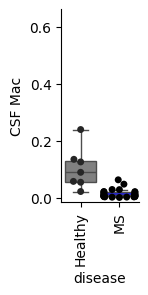

In [10]:
plt.figure(figsize=(1,2.5))
sns.swarmplot(data=df_freq, x='disease', y='CSF Mac', hue='disease', color='black', size=5, order=['Healthy', 'MS'])
sns.boxplot(data=df_freq, x='disease', y='CSF Mac', hue='disease', showfliers=False, order=['Healthy', 'MS'],
palette=['grey', 'blue'])

sns.despine()
plt.xticks(rotation=90)
plt.ylim(-0.015208586716118959,0.6603362113603796)
plt.savefig(f'../scanpy/{version}/graph/CSFmac_freq.pdf', bbox_inches='tight')

In [19]:
# mann whitney test
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

list_p = []
for celltype in df_freq.columns:
    if not celltype in ['patient', 'disease']:
        stat, p = mannwhitneyu(df_freq[df_freq['disease'] == 'Healthy'][celltype].values, 
            df_freq[df_freq['disease'] == 'MS'][celltype].values)
        list_p.append([celltype, p])
df_p = pd.DataFrame(list_p, columns=['celltype', 'p'])
df_p['fdr'] = multipletests(df_p['p'], method='fdr_bh')[1]
df_p['celltype'] = df_p['celltype'].str.replace(' ', '_')


In [20]:
df_p

,celltype,p,fdr
0,ASC,0.000452,0.001809
1,B_memory,0.000091,0.000457
2,B_naive,0.047052,0.104559
3,CD4_Tcm,0.504054,0.775467
4,CD4_Tem,0.802726,0.879062
5,CD4_Tnaive,0.006109,0.020362
6,CD8_Tem_emra,0.238961,0.434474
7,CD14_Mono,0.024313,0.060782
8,CD16_Mono,0.682014,0.879062
9,CSF_Mac,0.000011,0.000112


In [ ]:
sc.settings.set_figure_params(dpi=80, color_map='viridis', transparent=False, frameon=False)

In [75]:
adata_query.obs['disease'].value_counts()

disease
MS         191884
Healthy     20943
Name: count, dtype: int64

In [10]:
# perform ttest Baseline vs Healthy (CSF Mac)
from scipy import stats

stats.ttest_ind(df_freq[df_freq['disease'] == 'Healthy']['CSF Mac'],
                df_freq[df_freq['disease'] == 'MS']['CSF Mac'], equal_var=False)   

TtestResult(statistic=3.244057283156259, pvalue=0.0170872553095899, df=6.125778458596155)

In [11]:
# mann whitney U test
from scipy.stats import mannwhitneyu
mannwhitneyu(df_freq[df_freq['disease'] == 'Healthy']['CSF Mac'],
                df_freq[df_freq['disease'] == 'MS']['CSF Mac'], alternative='two-sided')

MannwhitneyuResult(statistic=183.0, pvalue=1.1153212422596706e-05)

In [12]:
adata_query.X = adata_query.layers['counts']
sc.pp.normalize_total(adata_query, target_sum=1e4)
sc.pp.log1p(adata_query)

normalizing counts per cell
    finished (0:00:00)


In [13]:
adata_query = adata_query[adata_query.obs['predictions_scanvi'] == 'CSF Mac'].copy()
# Obtain cluster-specific differentially expressed genes
sc.tl.rank_genes_groups(adata_query, groupby="disease", method="t-test_overestim_var", reference='Healthy')
df_ms = sc.get.rank_genes_groups_df(adata_query, group="MS")
df_ms.columns = ['names', 'scores_ms', 'logfoldchanges_ms', 'pvals_ms', 'pvals_adj_ms']
df_ms['mean_ms'] = list(adata_query.to_df().mean().loc[df_ms['names'].values])
df_ms.head()

ranking genes


/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:26)


,names,scores_ms,logfoldchanges_ms,pvals_ms,pvals_adj_ms,mean_ms
0,HLA-DRB5,16.366385,1.280016,2.388273e-58,1.797227e-55,1.599552
1,IFITM3,13.214291,0.904014,4.301577e-39,1.079010e-36,1.436449
2,IFI6,13.142141,1.529504,1.553788e-38,3.787741e-36,0.258747
3,IFI44L,12.761716,1.629912,1.710989e-36,3.948505e-34,0.234551
4,HBB,12.254036,3.797935,1.506214e-33,3.258695e-31,0.437961


In [14]:
df_ms.head(40)


,names,scores_ms,logfoldchanges_ms,pvals_ms,pvals_adj_ms,mean_ms
0,HLA-DRB5,16.366385,1.280016,2.388273e-58,1.797227e-55,1.599552
1,IFITM3,13.214291,0.904014,4.301577e-39,1.079010e-36,1.436449
2,IFI6,13.142141,1.529504,1.553788e-38,3.787741e-36,0.258747
3,IFI44L,12.761716,1.629912,1.710989e-36,3.948505e-34,0.234551
4,HBB,12.254036,3.797935,1.506214e-33,3.258695e-31,0.437961
5,HBA2,11.830544,3.808230,1.807318e-31,3.723935e-29,0.215036
6,FCGR2B,11.739613,1.048597,2.606330e-31,5.245391e-29,0.472820
7,HBA1,11.395322,3.886723,2.273857e-29,4.372880e-27,0.175465
8,PRDX1,11.212644,0.762548,9.005327e-29,1.694176e-26,1.001445
9,LGALS3BP,11.194462,1.630659,1.372276e-28,2.553910e-26,0.128087


In [46]:
# adata_query = sc.read('../scanpy/250411_MS_scanvi/merged.CSF_MSandHA_integrated_60704.scanvi.h5ad')
adata_query = sc.read('../scanpy/250417_MS_scanvi/merged.CSF_MSandHA_integrated_60704.scanvi.h5ad')

Only considering the two last: ['.scanvi', '.h5ad'].
Only considering the two last: ['.scanvi', '.h5ad'].


/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [47]:
msigdb = dc.get_resource('MSigDB')
msigdb

,genesymbol,collection,geneset
0,MAFF,chemical_and_genetic_perturbations,BOYAULT_LIVER_CANCER_SUBCLASS_G56_DN
1,MAFF,chemical_and_genetic_perturbations,ELVIDGE_HYPOXIA_UP
2,MAFF,chemical_and_genetic_perturbations,NUYTTEN_NIPP1_TARGETS_DN
3,MAFF,immunesigdb,GSE17721_POLYIC_VS_GARDIQUIMOD_4H_BMDC_DN
4,MAFF,chemical_and_genetic_perturbations,SCHAEFFER_PROSTATE_DEVELOPMENT_12HR_UP
...,...,...,...
3838543,PRAMEF22,go_biological_process,GOBP_POSITIVE_REGULATION_OF_CELL_POPULATION_PR...
3838544,PRAMEF22,go_biological_process,GOBP_APOPTOTIC_PROCESS
3838545,PRAMEF22,go_biological_process,GOBP_REGULATION_OF_CELL_DEATH
3838546,PRAMEF22,go_biological_process,GOBP_NEGATIVE_REGULATION_OF_DEVELOPMENTAL_PROCESS


In [48]:
# Filter by hallmark
msigdb = msigdb[msigdb['collection']=='hallmark']

# Remove duplicated entries
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]
msigdb

,genesymbol,collection,geneset
233,MAFF,hallmark,HALLMARK_IL2_STAT5_SIGNALING
250,MAFF,hallmark,HALLMARK_COAGULATION
270,MAFF,hallmark,HALLMARK_HYPOXIA
373,MAFF,hallmark,HALLMARK_TNFA_SIGNALING_VIA_NFKB
377,MAFF,hallmark,HALLMARK_COMPLEMENT
...,...,...,...
1449668,STXBP1,hallmark,HALLMARK_PANCREAS_BETA_CELLS
1450315,ELP4,hallmark,HALLMARK_PANCREAS_BETA_CELLS
1450526,GCG,hallmark,HALLMARK_PANCREAS_BETA_CELLS
1450731,PCSK2,hallmark,HALLMARK_PANCREAS_BETA_CELLS


In [49]:
dc.run_ora(
    mat=adata_query,
    net=msigdb,
    source='geneset',
    target='genesymbol',
    use_raw=False,
    verbose=True
)

12 features of mat are empty, they will be removed.
Running ora on mat with 212827 samples and 17296 targets for 50 sources.


  0%|          | 0/212827 [00:00<?, ?it/s]

In [50]:
acts = dc.get_acts(adata_query, obsm_key='ora_estimate')

# We need to remove inf and set them to the maximum value observed
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e

acts

/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 212827 × 50
    obs: 'patient', 'disease', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'SampleID', '_scvi_batch', 'cluster_L2_scanvi', '_scvi_labels', 'predictions_scanvi', 'leiden'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'leiden', 'log1p', 'neighbors', 'umap'
    obsm: 'X_scANVI', 'X_umap', 'ora_estimate', 'ora_pvals'

In [51]:
acts.var.index = acts.var.index.astype(str)
acts.write(f'../scanpy/{version}/ora_hallmark.h5ad')

In [52]:
acts = sc.read(f'../scanpy/{version}/ora_hallmark.h5ad')

/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [57]:
list_res = []
for clu in adata_query.obs['predictions_scanvi'].cat.categories:
    d = dc.rank_sources_groups(acts[acts.obs['predictions_scanvi']==clu], groupby='disease', reference='Healthy', method='t-test_overestim_var')
    d['celltype'] = clu
    list_res.append(d)
df_res = pd.concat(list_res)
df_res.to_csv(f'../scanpy/{version}/graph/MS_significant_adjusted_pvalues_by_celltype.csv')

In [6]:
df_res = pd.read_csv(f'../scanpy/{version}/graph/MS_significant_adjusted_pvalues_by_celltype.csv', index_col=0)

In [13]:
adata_query.obs['predictions_scanvi'].value_counts()

predictions_scanvi
CD4 Tcm            64044
CD4 Tnaive         39714
CD8 Tem_emra       37723
CD4 Tem            23180
Treg               12864
B memory           11304
NK CD56             6404
cDC2                4513
CSF Mac             3970
ASC                 2185
CD14 Mono           1650
Fibroblast          1098
B naive             1033
pDC                  847
Cycling T            750
NK CD16              500
Cycling Myeloid      413
cDC1                 388
migDC                141
CD16 Mono            106
Name: count, dtype: int64

In [14]:
list_celltypes_retain = list(adata_query.obs['predictions_scanvi'].value_counts()[adata_query.obs['predictions_scanvi'].value_counts() > 500].index)

In [16]:
import matplotlib.lines as mlines

In [7]:
list_celltypes_retain = ['CD4 Tcm',
 'CD8 Tem_emra',
 'CSF Mac',
 'CD4 Tem',
 'CD4 Tnaive',
 'CD14 Mono',
 'cDC2',
 'NK CD56',
 'Treg',
 'pDC',
 'B memory',
 'NK CD16',
 'Cycling Myeloid',
 'cDC1']

color_map = {
    'B naive': '#fdd9b4',
    'B memory': '#fd8c3b',
    'ASC': '#c54102',
    'CD4 Tnaive': '#d0e1f2',
    'CD4 Tcm': '#94c4df',
    'CD4 Tem': '#4a98c9',
    'Treg': '#1764ab',
    'CD8 Tem_emra': '#d3eecd',
    'Cycling T': '#157f3b',
    'NK CD16': '#e2e2ef',
    'NK CD56': '#61409b',
    'CD14 Mono': '#fdcab5',
    'CD16 Mono': '#fcaf93',
    'CSF Mac': '#fc9373',
    'migDC': '#fb7757',
    'pDC': '#f75b40',
    'cDC1': '#ee3a2c',
    'cDC2': '#d52221',
    'Cycling Myeloid': '#bc141a',
    'Fibroblast': '#808080'
}

In [8]:
# set categories order 
list_celltypes_cat = ['B naive', 'B memory', 'ASC', 'CD4 Tnaive', 'CD4 Tcm', 'CD4 Tem',
       'Treg', 'CD8 Tem_emra', 'Cycling T', 'NK CD16', 'NK CD56', 'CD14 Mono',
       'CD16 Mono', 'CSF Mac', 'migDC', 'pDC', 'cDC1', 'cDC2',
       'Cycling Myeloid', 'Fibroblast']

df_res.celltype = pd.Categorical(df_res.celltype,
    categories=list_celltypes_cat, ordered=True)
df_res = df_res.sort_values(['celltype','pvals_adj'])

/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_3991371/3242619417.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_positive = df_positive.groupby('celltype', group_keys=False).apply(
/tmp/ipykernel_3991371/3242619417.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_positive = df_positive.groupby('celltype', g

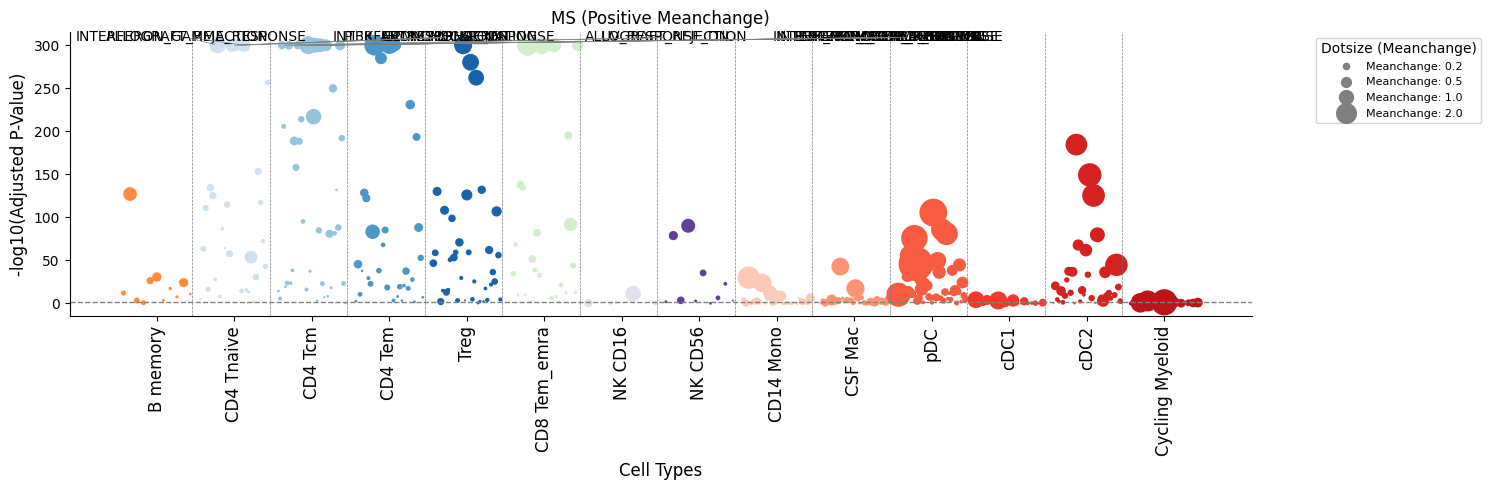

In [18]:
for group in ['MS']:
    df_plot = df_res[df_res['group'] == group].copy()

    # Calculate -log10 adjusted p-values and set sign by meanchange
    df_plot['neg_log10_pvals_adj'] = -np.log10(df_plot['pvals_adj']) * np.sign(df_plot['meanchange'])
    # replace inf with max value (300)
    df_plot['neg_log10_pvals_adj'] = df_plot['neg_log10_pvals_adj'].replace([np.inf, -np.inf], np.nan)
    df_plot['neg_log10_pvals_adj'] = df_plot['neg_log10_pvals_adj'].fillna(300)
    
    # Filter relevant celltypes
    df_plot = df_plot[df_plot['celltype'].isin(list_celltypes_retain)]
    df_plot['celltype'] = pd.Categorical(
        df_plot['celltype'],
        categories=pd.unique(df_plot['celltype']),
        ordered=True
    )

    # Remove 'HALLMARK_' prefix from names
    df_plot['names'] = df_plot['names'].str.replace('HALLMARK_', '', regex=False)

    # Keep only positive meanchange rows
    df_positive = df_plot[df_plot['meanchange'] > 0].copy()

    # Shuffle rows within each celltype group
    df_positive = df_positive.groupby('celltype', group_keys=False).apply(
        lambda x: x.sample(frac=1, random_state=42)
    ).reset_index(drop=True)


    # Shuffle rows within each celltype group
    # df_positive = df_positive.groupby('celltype', group_keys=False).apply(
    #     lambda x: x.sample(frac=1, random_state=42)
    # ).reset_index(drop=True)

    # Assign x-axis positions with equal width per celltype
    slots_per_celltype = 20  # Equal width for each celltype block
    gap = 2
    start_position = 0
    celltype_boundaries = []
    celltype_ticks = {}

    for celltype in df_positive['celltype'].unique():
        mask = df_positive['celltype'] == celltype
        n = mask.sum()
        indices = np.linspace(start_position, start_position + slots_per_celltype - 1, n)
        df_positive.loc[mask, 'position'] = indices
        celltype_boundaries.append(start_position + slots_per_celltype - 0.5)
        celltype_ticks[celltype] = start_position + (slots_per_celltype - 1) / 2
        start_position += slots_per_celltype + gap

    celltype_ticks = pd.Series(celltype_ticks)

    # Select top_n labels again from shuffled df_positive
    top_n = 15
    df_top_labels = df_positive[df_positive['meanchange'] > 0.2].nsmallest(top_n, 'pvals_adj')

    # Plotting
    plt.figure(figsize=(15, 5))
    for celltype, group_data in df_positive.groupby('celltype'):
        plt.scatter(
            group_data['position'],
            group_data['neg_log10_pvals_adj'],
            label=celltype,
            color=color_map.get(celltype, '#000000'),
            s=group_data['meanchange'] * 100,
            alpha=1
        )

    # Add FDR threshold line
    plt.axhline(y=-np.log10(0.05), color='gray', linestyle='--', linewidth=1, label='FDR Threshold (0.05)')

    # Add celltype boundary lines
    for boundary in celltype_boundaries[:-1]:
        plt.axvline(x=boundary, color='gray', linestyle='--', linewidth=0.5)

    # Add hallmark text labels
    texts = []
    for _, row in df_top_labels.iterrows():
        texts.append(plt.text(
            row['position'],
            row['neg_log10_pvals_adj'],
            row['names'],
            fontsize=10,
            color='k',
            ha='center'
        ))

    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5), expand_points=(2, 2))

    # X-axis ticks with celltype names
    plt.xticks(
        ticks=celltype_ticks,
        labels=celltype_ticks.index,
        rotation=90,
        fontsize=12
    )

    plt.xlabel('Cell Types', fontsize=12)
    plt.ylabel('-log10(Adjusted P-Value)', fontsize=12)
    plt.title(f'{group} (Positive Meanchange)', fontsize=12)

    # Create a dot size legend
    dot_sizes = [20, 50, 100, 200]
    size_labels = ['0.2', '0.5', '1.0', '2.0']
    legend_handles = [
        mlines.Line2D([], [], color='gray', marker='o', linestyle='None',
                    markersize=np.sqrt(size), label=f'Meanchange: {label}')
        for size, label in zip(dot_sizes, size_labels)
    ]
    plt.legend(handles=legend_handles, title="Dotsize (Meanchange)",
            bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

    plt.tight_layout()
    sns.despine()
    plt.grid(False)

    plt.savefig(f'../scanpy/{version}/graph/hallmark_manhattan_enrollment_cat_{group}.v3.pdf', dpi=300, bbox_inches='tight')

/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_3991371/3190628700.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_positive = df_positive.groupby('celltype', group_keys=False).apply(
/tmp/ipykernel_3991371/3190628700.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_positive = df_positive.groupby('celltype', g

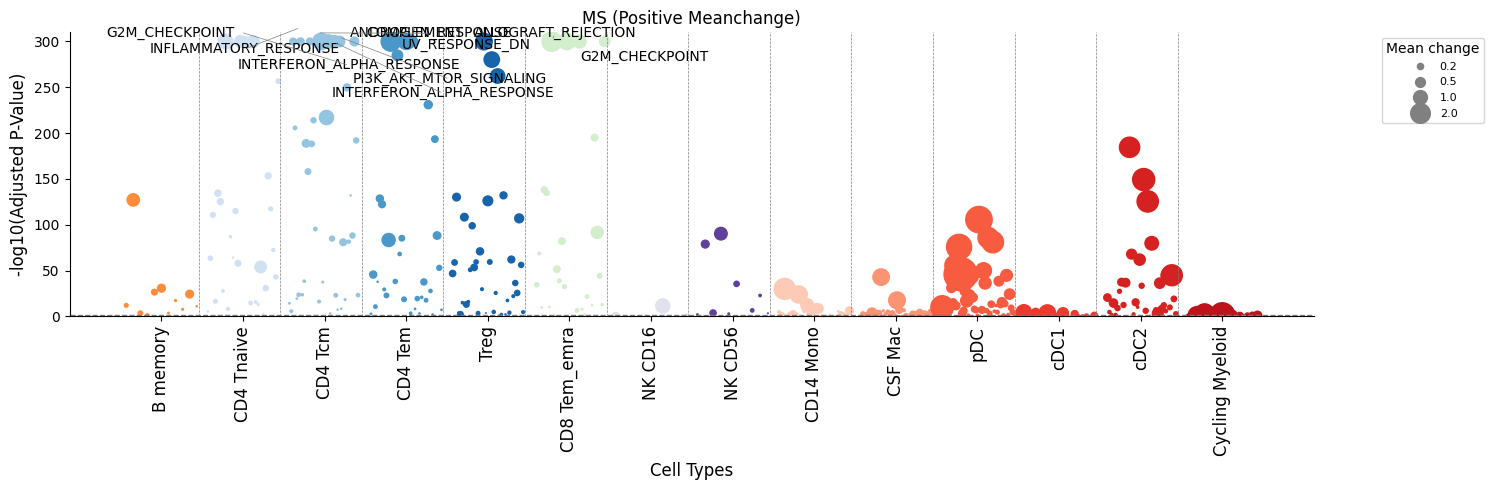

In [22]:
for group in ['MS']:
    df_plot = df_res[df_res['group'] == group].copy()

    # Calculate -log10 adjusted p-values and set sign by meanchange
    df_plot['neg_log10_pvals_adj'] = -np.log10(df_plot['pvals_adj']) * np.sign(df_plot['meanchange'])
    # replace inf with max value (300)
    df_plot['neg_log10_pvals_adj'] = df_plot['neg_log10_pvals_adj'].replace([np.inf, -np.inf], np.nan)
    df_plot['neg_log10_pvals_adj'] = df_plot['neg_log10_pvals_adj'].fillna(300)
    
    # Filter relevant celltypes
    df_plot = df_plot[df_plot['celltype'].isin(list_celltypes_retain)]
    df_plot['celltype'] = pd.Categorical(
        df_plot['celltype'],
        categories=pd.unique(df_plot['celltype']),
        ordered=True
    )

    # Remove 'HALLMARK_' prefix from names
    df_plot['names'] = df_plot['names'].str.replace('HALLMARK_', '', regex=False)

    # Keep only positive meanchange rows
    df_positive = df_plot[df_plot['meanchange'] > 0].copy()

    # Shuffle rows within each celltype group
    df_positive = df_positive.groupby('celltype', group_keys=False).apply(
        lambda x: x.sample(frac=1, random_state=42)
    ).reset_index(drop=True)


    # Shuffle rows within each celltype group
    # df_positive = df_positive.groupby('celltype', group_keys=False).apply(
    #     lambda x: x.sample(frac=1, random_state=42)
    # ).reset_index(drop=True)

    # Assign x-axis positions with equal width per celltype
    slots_per_celltype = 20  # Equal width for each celltype block
    gap = 2
    start_position = 0
    celltype_boundaries = []
    celltype_ticks = {}

    for celltype in df_positive['celltype'].unique():
        mask = df_positive['celltype'] == celltype
        n = mask.sum()
        indices = np.linspace(start_position, start_position + slots_per_celltype - 1, n)
        df_positive.loc[mask, 'position'] = indices
        celltype_boundaries.append(start_position + slots_per_celltype - 0.5)
        celltype_ticks[celltype] = start_position + (slots_per_celltype - 1) / 2
        start_position += slots_per_celltype + gap

    celltype_ticks = pd.Series(celltype_ticks)

    # Select top_n labels again from shuffled df_positive
    top_n = 10
    # df_top_labels = df_positive[df_positive['meanchange'] > 0.2].nsmallest(top_n, 'pvals_adj')
    df_top_labels = df_positive[(df_positive['meanchange'] > 0.2) & (df_positive['neg_log10_pvals_adj']==300)].sample(top_n)

    # Plotting
    plt.figure(figsize=(15, 5))
    for celltype, group_data in df_positive.groupby('celltype'):
        plt.scatter(
            group_data['position'],
            group_data['neg_log10_pvals_adj'],
            label=celltype,
            color=color_map.get(celltype, '#000000'),
            s=group_data['meanchange'] * 100,
            alpha=1
        )

    # Add FDR threshold line
    plt.axhline(y=-np.log10(0.05), color='gray', linestyle='--', linewidth=1, label='FDR Threshold (0.05)')

    # Add celltype boundary lines
    for boundary in celltype_boundaries[:-1]:
        plt.axvline(x=boundary, color='gray', linestyle='--', linewidth=0.5)

    # Add hallmark text labels
    texts = []
    for _, row in df_top_labels.iterrows():
        jitter = np.random.uniform(-15, 20)  # small noise to help adjust_text work
        texts.append(plt.text(
            row['position'],
            row['neg_log10_pvals_adj'] + jitter,
            row['names'],
            fontsize=10,
            color='k',
            ha='center'
        ))
    adjust_text(
        texts,
        arrowprops=dict(arrowstyle='-', color='gray', lw=0.5),
        expand_points=(5, 2),  # ← 横方向（x）が広く調整される
        expand_text=(15, 150),  # ← テキストの位置にも調整の余地を与える（オプション）
        only_move={'points': 'y', 'text': 'y'}  # ← ラベルをy方向だけにずらす
    )

    # X-axis ticks with celltype names
    plt.xticks(
        ticks=celltype_ticks,
        labels=celltype_ticks.index,
        rotation=90,
        fontsize=12
    )

    plt.xlabel('Cell Types', fontsize=12)
    plt.ylabel('-log10(Adjusted P-Value)', fontsize=12)
    plt.title(f'{group} (Positive Meanchange)', fontsize=12)

    # Create a dot size legend
    dot_sizes = [20, 50, 100, 200]
    size_labels = ['0.2', '0.5', '1.0', '2.0']
    legend_handles = [
        mlines.Line2D([], [], color='gray', marker='o', linestyle='None',
                    markersize=np.sqrt(size), label=f'{label}')
        for size, label in zip(dot_sizes, size_labels)
    ]
    plt.legend(handles=legend_handles, title="Mean change",
            bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

    plt.tight_layout()
    sns.despine()
    plt.grid(False)
    plt.ylim(0,310)

    plt.savefig(f'../scanpy/{version}/graph/hallmark_manhattan_enrollment_cat_{group}.v3.1.pdf', dpi=300, bbox_inches='tight')